In [1]:
import pandas as pd
import numpy as np
import os
import random

import warnings

warnings.filterwarnings(action='ignore')

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


In [2]:
path = '/opt/ml/input/data/'
# # train = pd.read_csv(path + 'train_data.csv')
# # test = pd.read_csv(path + 'test_data.csv')
dat = pd.read_csv(path + 'FE_total2.csv')

dat = dat.sort_values(by = ['userID', 'Timestamp'], ascending= False)
dat['tem'] = 0

_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] == -1]

In [3]:
path = '/opt/ml/input/data/'
# # train = pd.read_csv(path + 'train_data.csv')
# # test = pd.read_csv(path + 'test_data.csv')
dat = pd.read_csv(path + 'FE_total2.csv')

# 어짜피 시간순으로 정렬되어 있음. 시간 역순으로 정렬함.
dat = dat.loc[::-1]
#dat = dat.sort_values(by = ['userID', 'Timestamp'], ascending= False)
dat['tem'] = 1
dat['seq'] = dat.groupby('userID')['tem'].apply(lambda x : x.cumsum())
dat.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solve_time,b_category,test_category,problem_id,...,last_answerCode7,last_answerCode8,last_answerCode9,last_answerCode10,year,month,day,hour,tem,seq
2526699,7441,A040165004,A040000165,1,2020-08-21 01:08:49,8836,73,4,4165,4,...,0,0,1,1,2020,8,21,1,1,1
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46,4,4165,3,...,0,1,1,1,2020,8,21,1,1,2
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11,4,4165,2,...,1,1,1,1,2020,8,21,1,1,3
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0,4,4165,1,...,1,1,1,1,2020,8,21,1,1,4
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24,3,3071,5,...,1,1,1,1,2020,6,5,6,1,5


In [4]:
test_user_id = dat[dat['answerCode'] == -1]['userID'].unique()
test_y = dat[dat['answerCode'] == -1]
test_x = dat[dat['userID'].isin(test_user_id)]
test_x = test_x[(test_x['seq'] > 1) & (test_x['seq'] <= 100 + 1)]

In [5]:
def data_merge(_train_x, _train_y): 
    # _train_x : 값 제공하는 전체 DB, _train_y : 현재 맞춰야 하는 유저와 아이템 상태.

    # 문제별로 평균값, 총 풀어진 개수 구하기.
    item1 = _train_x.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
    item1.columns = ["item_mean", 'item_sum']
    item1.reset_index(inplace=True)
    _train_x = pd.merge(_train_x, item1[['assessmentItemID','item_mean']], on=['assessmentItemID'], how='left')

    # 유저 단위 변수 추가

    # 유저가 평균적으로 얼마나 맞는지, 또 몇 문제 풀었는지.
    tem1 = _train_x.groupby('userID')['answerCode']
    tem1 = pd.DataFrame({'answer_mean' : tem1.mean(), 'answer_cnt':tem1.count()}).reset_index()
    # 유저가 평균적으로 몇 분안에 문제를 풀었는지.
    tem2 = _train_x.groupby('userID')['solve_time']
    tem2 = pd.DataFrame({'time_mean' : tem2.mean()}).reset_index()
    # 유저의 태그를 붙인 것 같은데 정확히 뭔지 모르겠음. => 최빈 태그라고 함(mode)
    #tem3 = pd.DataFrame({'tag_mode' : _train_x.groupby('userID')['KnowledgeTag'].agg(pd.Series.mode)})
    #tem3['tag_mode'] = tem3['tag_mode'].apply(lambda x : x if str(type(x)) =="<class 'numpy.int64'>" else x[0])
    # 유저가 지금까지 푼 문제의 평균 정답률은 어떻게 되는지 구하기.(어려운 문제를 풀어왔는가?)
    tem5 = _train_x.groupby(['userID'])['item_mean'].agg(['mean']).reset_index()
    tem5.columns = ["userID", 'user_item_mean']
    # tem4 = _train_x.groupby('userID')['answerCode'].apply(lambda x : x.iloc[-3:])
    # tem4 = pd.DataFrame({'last3_mean' : tem4.groupby('userID').mean()})

    user_df = pd.merge(tem1, tem2, on=['userID'], how='left')
    #user_df = pd.merge(user_df, tem3, on=['userID'], how='left')
    user_df = pd.merge(user_df, tem5, on=['userID'], how='left')
    # user_df = pd.merge(user_df, tem4, on=['userID'], how='left')

    _train_y = pd.merge(_train_y[['userID', 'assessmentItemID', 'answerCode','last_answerCode',
    'last_answerCode2','last_answerCode3','last_answerCode4','last_answerCode5','last_answerCode6',
    'last_answerCode7','last_answerCode8','last_answerCode9','last_answerCode10']], user_df, on=['userID'], how='left')

    # 아이템 단위 변수 추가.

    # 해당 문제는 평균 정답률이 어떻게 되는가? + 학생이 몇 번이나 풀었던가?
    _train_y = pd.merge(_train_y, item1, on=['assessmentItemID'], how='left')
    # 해당 문제는 평균 풀이 시간이 어떻게 되는가?
    item2 = _train_x.groupby(['assessmentItemID'])['solve_time'].agg(['mean'])
    item2.columns = ["item_time_mean"]
    item2.reset_index(inplace=True)
    _train_y = pd.merge(_train_y, item2, on=['assessmentItemID'], how='left')

    return _train_y.drop(['userID','assessmentItemID'],axis=1)

In [6]:
k = 100 # 100개까지를 표본으로 사용할 것.
n = 1700 # 데이터 증강 횟수

# test 데이터 제작
test_user_id = dat[dat['answerCode'] == -1]['userID'].unique()
test = dat[dat['userID'].isin(test_user_id)].copy()
test_y = test[test['seq'] == 1]
test_x = test[(test['seq'] > 1) & (test['seq'] <= k + 1)]
dat['seq'] = dat.apply(lambda x : x['seq'] - 1  if x['userID'] in test_user_id else x['seq'], axis = 1)
#dat[dat['userID'].isin(test_user_id)]['seq'] -= 1
test_data = data_merge(test_x, test_y)

train = dat.copy()

# valid 데이터 제작
train_user_id = train[train['seq'] == 2]['userID'].unique()
train = train[train['userID'].isin(train_user_id)].copy()
train_y = train[train['seq'] == 1]
train_x = train[train['seq'] > 1]

train = train_x.copy()
train['seq'] -= 1
train_x = train_x[train_x['seq'] <= k + 1]
valid_data = data_merge(train_x, train_y)

# train 데이터 제작
train_user_id = train[train['seq'] == 2]['userID'].unique()
train = train[train['userID'].isin(train_user_id)].copy()
train_y = train[train['seq'] == 1]
train_x = train[train['seq'] > 1]

train = train_x.copy()
train['seq'] -= 1
train_x = train_x[train_x['seq'] <= k + 1]
train_data = data_merge(train_x, train_y)

# train 데이터 증강.
for i in range(n):
    train_user_id = train[train['seq'] == 2]['userID'].unique()
    train = train[train['userID'].isin(train_user_id)].copy()
    train_y = train[train['seq'] == 1]
    train_x = train[train['seq'] > 1]

    train = train_x.copy()
    train['seq'] -= 1
    train_x = train_x[train_x['seq'] <= k + 1]
    train_data_new = data_merge(train_x, train_y)
    train_data = pd.concat([train_data, train_data_new])

train_data = train_data[train_data['answer_cnt'] >= 14]

In [7]:
train_data.dropna(inplace = True)
train_data.to_csv(path + 'FE/train100.csv', index= False)

OSError: Cannot save file into a non-existent directory: '/opt/ml/input/data/FE'

In [8]:
model = LGBMClassifier(random_state=1998, n_estimators=6000, learning_rate=0.003, subsample = 0.7, colsample_bytree = 0.7, max_depth=10, num_leaves = 100, reg_lambda = 0.0001, reg_alpha = 0.0001, min_child_samples = 100)
model.fit(train_data.drop(['answerCode'],axis=1), train_data['answerCode'], eval_metric = 'AUC',
eval_set=(valid_data.drop(['answerCode'],axis=1), valid_data['answerCode']), verbose=200)
preds = model.predict_proba(train_data.drop(['answerCode'],axis=1))[:,1]

acc = accuracy_score(train_data['answerCode'], np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(train_data['answerCode'], preds)
print(f'TRAIN AUC : {auc} ACC : {acc}\n')

preds = model.predict_proba(valid_data.drop(['answerCode'],axis=1))[:,1]
acc = accuracy_score(valid_data['answerCode'], np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(valid_data['answerCode'], preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')
# train 대비 Valid가 낮다. valid는 리더보드와 거의 동일하다.
# train에 모델 과적합. => 과적합 방지 하이퍼파라미터 튜닝 + 데이터 증강필요?

[200]	valid_0's auc: 0.795267	valid_0's binary_logloss: 0.636258
[400]	valid_0's auc: 0.796	valid_0's binary_logloss: 0.59084
[600]	valid_0's auc: 0.796822	valid_0's binary_logloss: 0.569568
[800]	valid_0's auc: 0.79764	valid_0's binary_logloss: 0.559612
[1000]	valid_0's auc: 0.798336	valid_0's binary_logloss: 0.55392
[1200]	valid_0's auc: 0.798899	valid_0's binary_logloss: 0.550738
[1400]	valid_0's auc: 0.799404	valid_0's binary_logloss: 0.548575
[1600]	valid_0's auc: 0.799762	valid_0's binary_logloss: 0.547181
[1800]	valid_0's auc: 0.799977	valid_0's binary_logloss: 0.54627
[2000]	valid_0's auc: 0.80018	valid_0's binary_logloss: 0.545607
[2200]	valid_0's auc: 0.800311	valid_0's binary_logloss: 0.545168
[2400]	valid_0's auc: 0.800464	valid_0's binary_logloss: 0.544751
[2600]	valid_0's auc: 0.800604	valid_0's binary_logloss: 0.544418
[2800]	valid_0's auc: 0.800712	valid_0's binary_logloss: 0.544178
[3000]	valid_0's auc: 0.800808	valid_0's binary_logloss: 0.543989
[3200]	valid_0's auc: 

Text(0.5, 1.0, 'Feature Importance')

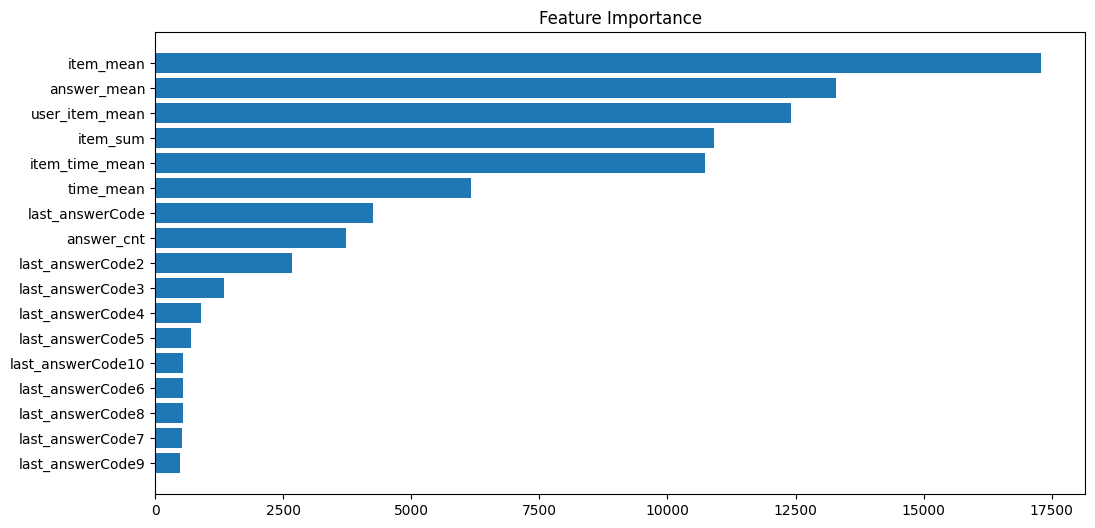

In [ ]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(valid_data.drop(['answerCode'],axis=1).columns)[sorted_idx])
plt.title("Feature Importance")

In [ ]:
# submission 제출하기 위한 코드

test_pred = model.predict_proba(test.drop(['answerCode'],axis=1))[:,1]
test['prediction'] = test_pred
submission = test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('../output/sequence_50LGBM.csv', index = False)